# Low Rank Tensor Fusion Model - CMU-MOSI Dataset

In [1]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Sentiment-Analysis

Cloning into 'Multimodal-Sentiment-Analysis'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 362 (delta 0), reused 10 (delta 0), pack-reused 347 (from 1)
Receiving objects: 100% (362/362), 285.91 MiB | 41.18 MiB/s, done.
Resolving deltas: 100% (184/184), done.
Updating files: 100% (68/68), done.


In [2]:
import gdown

file_id = "1zFOBHijVppTiyteSsi0aTFYPEsda_AOk"
destination = "mosei_raw.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk
From (redirected): https://drive.google.com/uc?id=1zFOBHijVppTiyteSsi0aTFYPEsda_AOk&confirm=t&uuid=97d3d871-bf69-40ef-b525-e277e8ac52cc
To: /content/mosei_raw.pkl
100%|██████████| 9.94G/9.94G [00:57<00:00, 172MB/s]


'mosei_raw.pkl'

## Importing Libraries

In [3]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Sentiment-Analysis/src')

## Importing Helper Functions

In [4]:
from loader import get_dataloader
from unimodals.modules import GRUWithLinear, MLP
from fusions.modules import LowRankTensorFusion
from training.supervised import train, test
from utils import get_default_device, save_results

## Loading the Dataset

In [5]:
train_data, valid_data, test_data = get_dataloader('/content/mosei_raw.pkl')

In [6]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [17]:
encoders = [
    GRUWithLinear(713, 64, 32, dropout=True, has_padding=True).to(device),
    GRUWithLinear(74, 128, 32, dropout=True, has_padding=True).to(device),
    GRUWithLinear(300, 512, 128, dropout=True, has_padding=True).to(device)
]

head = MLP(128, 512, 1).to(device)

fusion = LowRankTensorFusion([32, 32, 128], 128, 32).to(device)

## Training

In [18]:
OUTPUT_MODEL_FILE_NAME = "MOSEI_Low_Rank_Tensor_Fusion"
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    early_stop=False,
    is_packed=True,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]
Train Loss: 0.7480
Valid Loss: 0.6498
Saving Best

Epoch [2/100]
Train Loss: 0.6460
Valid Loss: 0.6184
Saving Best

Epoch [3/100]
Train Loss: 0.6120
Valid Loss: 0.6022
Saving Best

Epoch [4/100]
Train Loss: 0.5768
Valid Loss: 0.5963
Saving Best

Epoch [5/100]
Train Loss: 0.5442
Valid Loss: 0.5944
Saving Best

Epoch [6/100]
Train Loss: 0.5073
Valid Loss: 0.6028

Epoch [7/100]
Train Loss: 0.4656
Valid Loss: 0.6008

Epoch [8/100]
Train Loss: 0.4207
Valid Loss: 0.6266

Epoch [9/100]
Train Loss: 0.3801
Valid Loss: 0.6383

Epoch [10/100]
Train Loss: 0.3465
Valid Loss: 0.6218

Epoch [11/100]
Train Loss: 0.3134
Valid Loss: 0.6349

Epoch [12/100]
Train Loss: 0.2890
Valid Loss: 0.6481

Epoch [13/100]
Train Loss: 0.2643
Valid Loss: 0.6263

Epoch [14/100]
Train Loss: 0.2492
Valid Loss: 0.6432

Epoch [15/100]
Train Loss: 0.2300
Valid Loss: 0.6634

Epoch [16/100]
Train Loss: 0.2178
Valid Loss: 0.6314

Epoch [17/100]
Train Loss: 0.2097
Valid Loss: 0.6428

Epoch [18/100]
Train Loss: 0.19

Text(0.5, 1.0, 'Loss vs. No. of epochs')

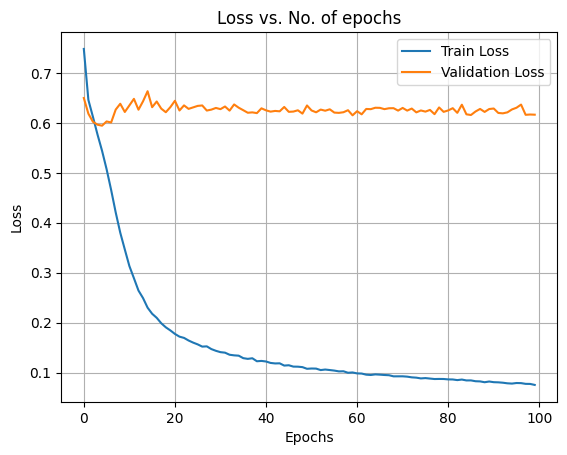

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [20]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [21]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_dataloaders_all=test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-21-ece7b266be51>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)


Recall: 81.3858% | Total Accuracy: 70.4419%
Inference Time: 2s425ms
Inference Params: 1616641
